In [1]:
import copy

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from tqdm import tqdm
import seaborn as sns

from ucn.models import SMCN
from src.trainer import SMCNTrainer
from src.dataset import ChunkDataset
from src.utils import plot_range, compute_cost, freq_filter, uncertainty_estimation

sns.set()
plt.rcParams.update({
    'font.size': 25,
    'figure.figsize': (25, 5)
})

torch.manual_seed(36)

%load_ext autoreload
%autoreload 2

## Generate noisy dataset from the model

### Sample dataset

In [2]:
BATCH_SIZE = 4
EPOCHS = 200
T = 50
N_SAMPLES = 100

D_IN = 4
D_EMB = 2
D_OUT = 3
N = 200

SIGMA_Y2 = 0.25
SIGMA_X2 = 0.1

model = SMCN(D_IN, D_EMB, D_OUT, n_particles=1)

# Sets the range of a few parameters to avoid low signal to noise ratio
model._f._linear.weight.data = torch.randn(D_OUT, D_EMB) * 0.2 + 0.8
model._g.weight_hh.data = torch.randn(D_EMB, D_EMB) * 0.2 + 0.8
model._g.weight_ih.data = torch.randn(D_EMB, D_IN)*0.2 + 0.8
model.sigma_x2 = torch.eye(D_EMB)*SIGMA_X2
model.sigma_y2 = torch.eye(D_OUT)*SIGMA_Y2
params_simulation = copy.deepcopy(model.state_dict())

# Generate zeros inputs
u = torch.zeros(T, N_SAMPLES, D_IN)

# Compute outputs with added noise on the hidden state with variance sigma_x
with torch.no_grad():
    y = model(u, noise=True).view((T, N_SAMPLES, D_OUT))

# Add noise on the observations with variance sigma_y
y = y + torch.randn(y.shape) * np.sqrt(SIGMA_Y2)

The dataset is sampled from a model defined as


\begin{equation*}
        \left\{
        \begin{aligned}
                x_{t+1} & = \tanh(W_{xx} x_{t} + W_{xu} u_{t+1} + b_x) + \eta_{t+1} \\
                y_{t+1} & = W_y x_{t+1}^L + b_y + \epsilon_{t+1}                        \\
        \end{aligned}
        \right.
\end{equation*}

### Plot model's prediction on a sample

Discrepency between observations and predictions are due to the added observation noise, which the traditionnal model cannot account for

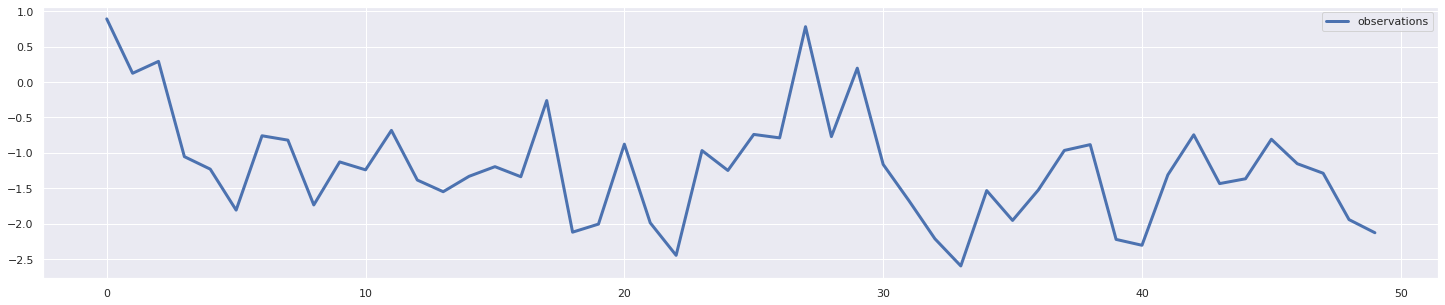

In [3]:
dataset = ChunkDataset(y=y.transpose(0, 1).numpy(),
                      u=u.transpose(0, 1).numpy())
dataloader = DataLoader(dataset,
                        batch_size=BATCH_SIZE,
                        num_workers=4,
                        shuffle=True
                       )

# Plot model predictions for a sample
for u, y in dataloader:
    u = u.transpose(0, 1)
    y = y.transpose(0, 1)
    break

plt.figure(figsize=(25, 5))
plt.plot(y[:, 0, 0], lw=3, label='observations')
plt.legend()
plt.show()

## Estimation by gradient and EM

In [4]:
# Set particules
model.N = N

# Freeze the model
for p in model.parameters():
    p.requires_grad = False
    
# Randomize f and sigma parameters to train
for p in model._f.parameters():
    p.requires_grad = True
    p.data.normal_()
model._sigma_y.requires_grad = True
model.sigma_x2 = torch.diag(torch.randn(D_EMB).abs())
model.sigma_y2 = torch.diag(torch.randn(D_OUT).abs())

In [5]:
# Train model
train_model = SMCNTrainer(model, lr=1e-2)
trainer = pl.Trainer(max_epochs=EPOCHS, gpus=0)
trainer.fit(train_model, dataloader)

GPU available: True, used: False
TPU available: None, using: 0 TPU cores
/home/mrmojo/Code/these/uncertaintyQuantification/.env/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)

  | Name   | Type | Params
--------------------------------
0 | _model | SMCN | 150   
--------------------------------
12        Trainable params
138       Non-trainable params
150       Total params


Epoch 199: 100%|██████████| 25/25 [00:02<00:00, 10.01it/s, loss=2.62, v_num=62]


1

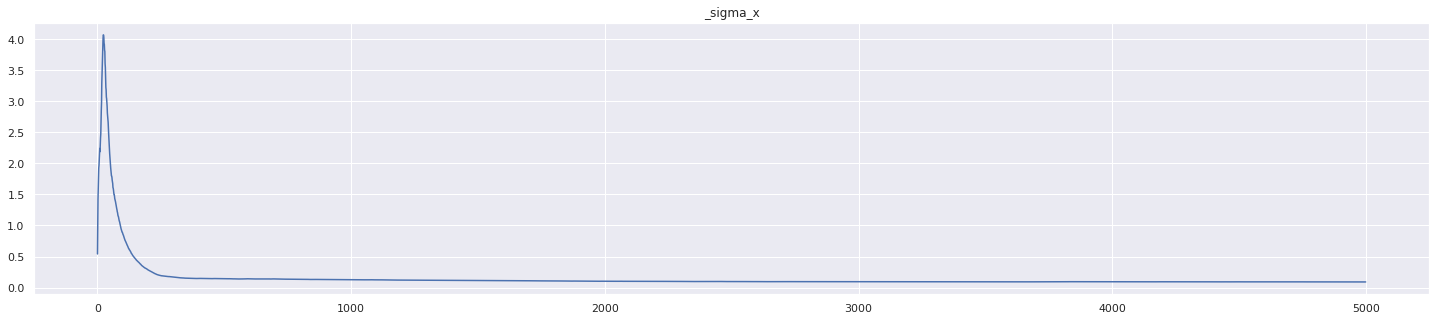

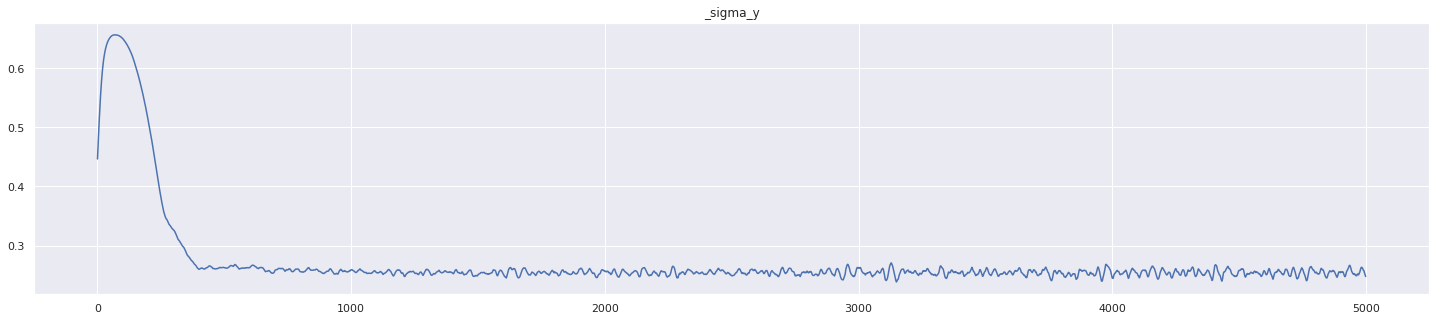

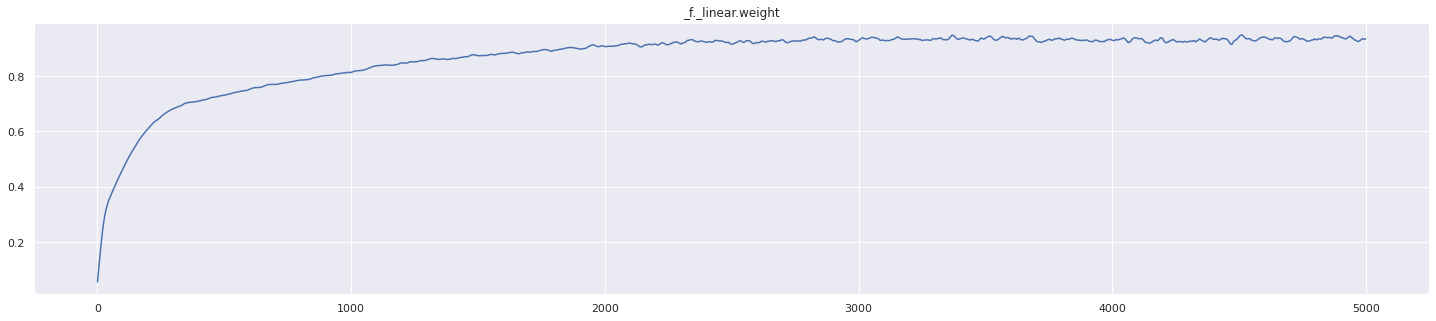

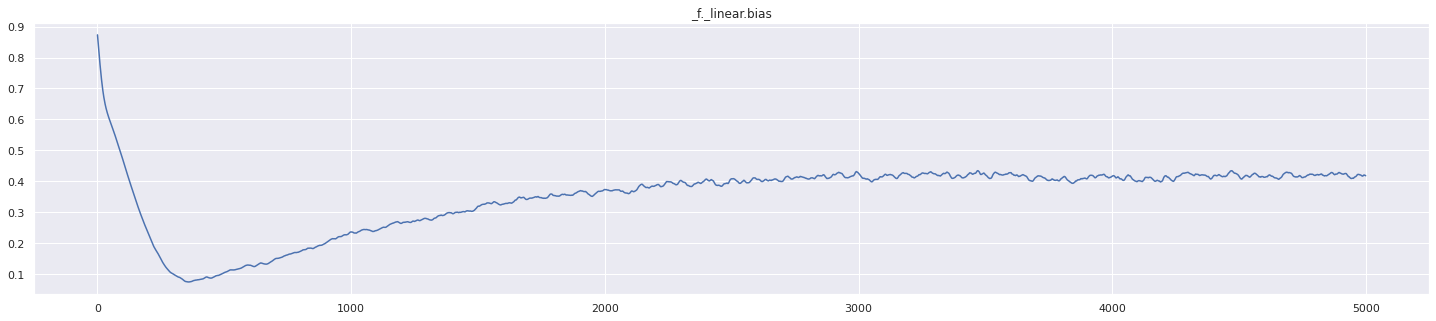

In [6]:
# Plot parameter evolutions
l = len(train_model._hist['_sigma_y'])

for param_name in model.state_dict().keys():
    if param_name.startswith('_input'):
        continue
    elif param_name in ['_sigma_y', '_sigma_x']:
        param_hist = np.array(train_model._hist[param_name]).squeeze().mean(-1)
    else:
        param_hist = np.array(train_model._hist[param_name]).squeeze().reshape(l, -1).mean(-1)
        
    if param_hist.std() < 1e-3:
        continue
    plt.figure()
    plt.plot(param_hist)
    plt.title(param_name)

## Inference

### Smoother predictions

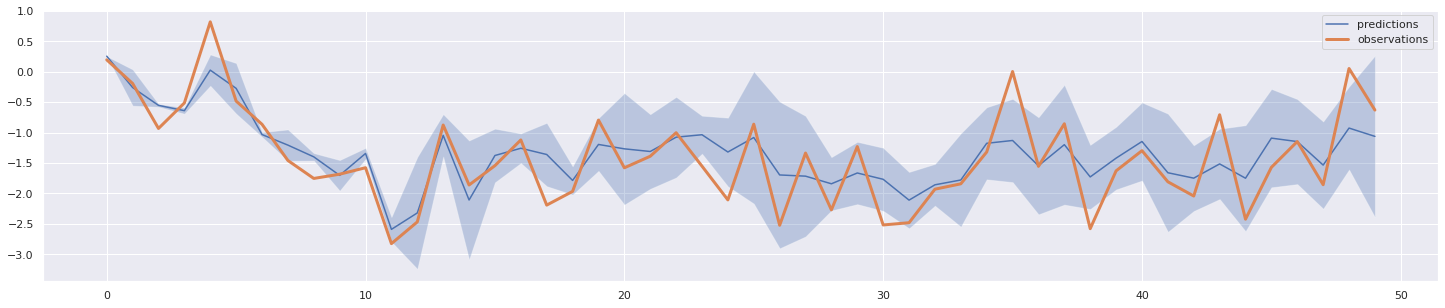

In [7]:
for u, y in dataloader:
    u = u.transpose(0, 1)
    y = y.transpose(0, 1)
    break

with torch.no_grad():
    netout = model(u=u,
                   y=y,
                   noise=True)

netout = model.smooth_pms(netout, model.I).numpy()

plt.figure(figsize=(25, 5))
plot_range(netout[:, 0, :, 0], label='predictions')
plt.plot(y[:, 0, 0], lw=3, label='observations')
plt.legend()

plt.show()

### Predictions at $t+1$

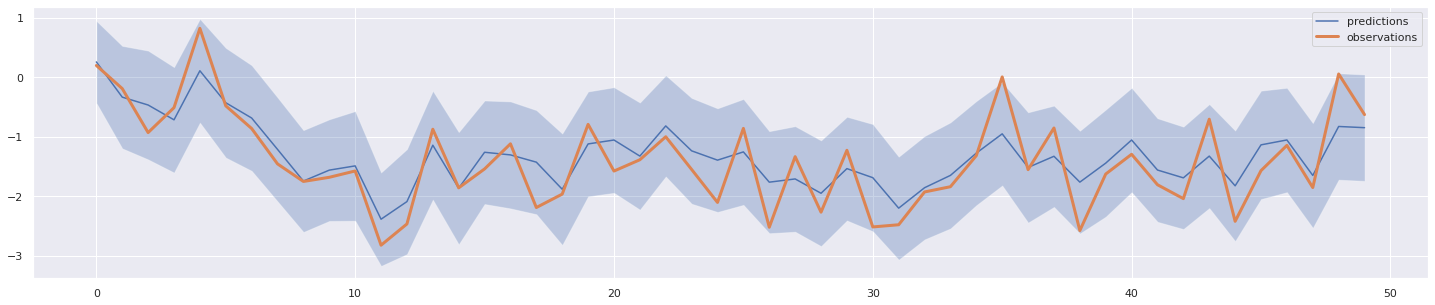

Accuracy: 98%


In [8]:
idx_out = 0

# Plot filter's prediction for each time step
with torch.no_grad():
    netout = model(u=u,
                   y=y,
                   noise=True)

netout = netout[:, 0, :, idx_out]

# netout = netout + torch.randn(netout.shape) * np.sqrt(model.sigma_y.detach())-0.1
mean = netout * model.W[:, 0]
mean = mean.sum(-1)

std = netout.square() * model.W[:, 0]
std = std.sum(-1)
std = std + model.sigma_y2.detach().numpy()[idx_out, idx_out] - np.square(mean)
std = std.flatten()

std = std.numpy()
mean = mean.numpy()

# plt.figure(figsize=(30, 8))
plt.plot(mean, label='predictions')
plt.fill_between(np.arange(len(mean)), mean - 3*std, mean + 3*std, alpha=.3)
# plt.fill_between(np.arange(len(mean)), mean - 3*std_wrong, mean + 3*std_wrong, alpha=.3)
plt.plot(y[:, 0, 0], lw=3, label='observations')
plt.legend()
plt.show()

accuracy = (((mean - 3*std) < y[:, 0, 0].numpy()) & (y[:, 0, 0].numpy() < (mean + 3*std))).sum() / mean.shape[0]
print(f'Accuracy: {accuracy*100:.0f}%')

#### Compute uncertainty accuracy on the entire dataset

Compute prediction at $t+1$, and compute the accuracy score based on wether the observation is inside the predicted interval. Average this score on the entire dataset. We expect a **score close to 0.98%**.

In [9]:
print(f"Uncertainty estimation: {uncertainty_estimation(model, dataloader)*100:.1f}%")

Uncertainty estimation: 96.0%


### Plot particules with $\alpha \propto \omega$

We plot each trajectory, with a transparancy setting proportionnal to their associated weight. This graph aims at visualizing particle degenerecence.

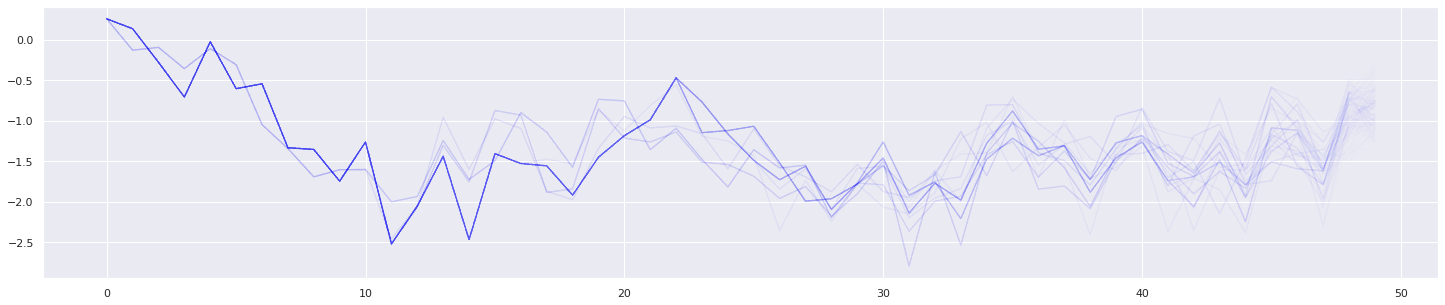

In [10]:
with torch.no_grad():
    netout = model(u=u,
                   y=y,
                   noise=True)

netout = model.smooth_pms(netout, model.I)

batch_idx = 0

netout = netout[:, batch_idx, :, idx_out].numpy()
w = model.w[batch_idx]
# w = torch.softmax(w, dim=0)
w = w.numpy()

# plt.plot(y[:, batch_idx].squeeze().numpy(), '--', lw=3, alpha=0.6, c='green')
for trajectory, weight in zip(netout.T, w):
    plt.plot(trajectory, alpha=weight, c='blue')